## MISPACE 2025
### Teja Koduru & Cindy Yang

    #### TODO LIST:

    1. Data resampling based on lat/lon (For every cell in the ice data grid, 1024x1024, find the closest lat/lon point in the weather data grid, 361x72 and the HRRR grid, then create 1024x1024 grids of those as well)
    2. Data resampling based on time (Make sure all datasets are based on teh same time)
    3. Construct training samples (initial ICE, 24 hour HRRR data in 1hr increments, 24 hour GFS data in 6hr increments, output ICE after 24hrs) MAKE SURE TO DO RANDOM CROPPING! Generates more training samples, but can we just give it a 1024x1024 for the output later? make sure we can

    4. Create model

#### Data visulization

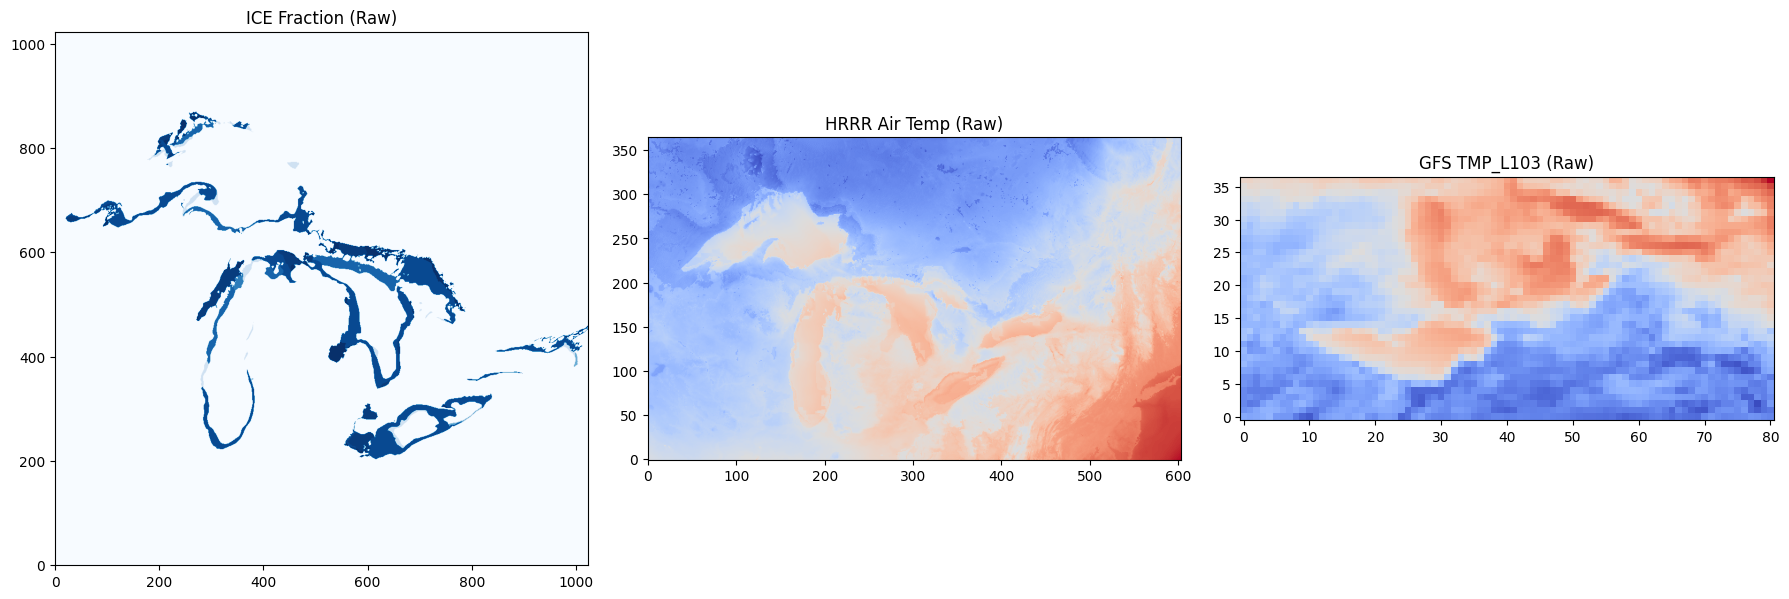

In [19]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

# Load datasets
ice_ds  = xr.open_dataset("test/glsea_ice_test_initial_condition.nc")
hrrr_ds = xr.open_dataset("test/hrrr_weather_test_period.nc")
gfs_ds  = xr.open_dataset("test/gfs_weather_test_period.nc")

# ICE: single snapshot
ice_data = ice_ds['sst'].values
ice_fraction = np.zeros_like(ice_data, dtype=np.float32)
ice_fraction[ice_data < 0] = -ice_data[ice_data < 0]

# HRRR: first time step
hrrr_data = hrrr_ds['air_temp'].isel(time=0).values  # shape (365, 604)

# GFS: first time step
gfs_data = gfs_ds['TMP_L103'].isel(time=0).values  # shape (37, 81)

# Plot before and after
fig, axs = plt.subplots(1, 3, figsize=(18, 12))

# Raw data
axs[0].imshow(ice_fraction, cmap='Blues', origin='lower')
axs[0].set_title('ICE Fraction (Raw)')

axs[1].imshow(hrrr_data, cmap='coolwarm', origin='lower')
axs[1].set_title('HRRR Air Temp (Raw)')

axs[2].imshow(gfs_data, cmap='coolwarm', origin='lower')
axs[2].set_title('GFS TMP_L103 (Raw)')

plt.tight_layout()
plt.show()


In [ ]:
import xarray as xr

# Replace this with your file
filename  = "train/gfs_20190111-20190201.nc"
ds = xr.open_dataset(filename)

print(f"\nFile: {filename}\n")
print("Variables and their dimensions:")
for var in ds.data_vars:
    print(f" - {var}: {ds[var].dims} | shape: {ds[var].shape}")

print("\nCoordinates:")
for coord in ds.coords:
    print(f" - {coord}: shape {ds[coord].shape}")

print("\nAttributes:")
for attr in ds.attrs:
    print(f" - {attr}: {ds.attrs[attr]}")



File: test/glsea_ice_test_initial_condition.nc

Variables and their dimensions:
 - sst: ('lat', 'lon') | shape: (1024, 1024)

Coordinates:
 - lon: shape (1024,)
 - lat: shape (1024,)

Attributes:


In [21]:
import xarray as xr

# Replace this with your file
filename = "test/hrrr_weather_test_period.nc"
ds = xr.open_dataset(filename)

print(f"\nFile: {filename}\n")
print("Variables and their dimensions:")
for var in ds.data_vars:
    print(f" - {var}: {ds[var].dims} | shape: {ds[var].shape}")

print("\nCoordinates:")
for coord in ds.coords:
    print(f" - {coord}: shape {ds[coord].shape}")

print("\nAttributes:")
for attr in ds.attrs:
    print(f" - {attr}: {ds.attrs[attr]}")




File: test/hrrr_weather_test_period.nc

Variables and their dimensions:
 - PRATE_surface: ('time', 'y', 'x') | shape: (97, 365, 604)
 - air_temp: ('time', 'y', 'x') | shape: (97, 365, 604)
 - pressure_sea_level: ('time', 'y', 'x') | shape: (97, 365, 604)
 - rel_humidty: ('time', 'y', 'x') | shape: (97, 365, 604)
 - sky_cover: ('time', 'y', 'x') | shape: (97, 365, 604)
 - windu: ('time', 'y', 'x') | shape: (97, 365, 604)
 - windv: ('time', 'y', 'x') | shape: (97, 365, 604)

Coordinates:
 - latitude: shape (365, 604)
 - longitude: shape (365, 604)
 - time: shape (97,)
 - x: shape (604,)
 - y: shape (365,)

Attributes:
 - Conventions: CF-1.0
 - GRIB2_grid_template: 30
 - NCO: netCDF Operators version 5.3.4 (Homepage = http://nco.sf.net, Code = http://github.com/nco/nco, Citation = 10.1016/j.envsoft.2008.03.004)
 - nco_openmp_thread_number: 1
 - History: 
 - history: Tue Nov  4 11:21:16 2025: ncatted -O -a history,global,o,c, hrrr_test_v2.nc hrrr_test_v2.nc



In [22]:
import xarray as xr

# Replace this with your file
filename = "test/gfs_weather_test_period.nc"
ds = xr.open_dataset(filename)

print(f"\nFile: {filename}\n")
print("Variables and their dimensions:")
for var in ds.data_vars:
    print(f" - {var}: {ds[var].dims} | shape: {ds[var].shape}")

print("\nCoordinates:")
for coord in ds.coords:
    print(f" - {coord}: shape {ds[coord].shape}")

print("\nAttributes:")
for attr in ds.attrs:
    print(f" - {attr}: {ds.attrs[attr]}")



File: test/gfs_weather_test_period.nc

Variables and their dimensions:
 - PRATE_L1_Avg_1: ('time', 'lat', 'lon') | shape: (17, 37, 81)
 - PRES_L1: ('time', 'lat', 'lon') | shape: (17, 37, 81)
 - R_H_L103: ('time', 'lat', 'lon') | shape: (17, 37, 81)
 - TMP_L103: ('time', 'lat', 'lon') | shape: (17, 37, 81)
 - T_CDC_L10: ('time', 'lat', 'lon') | shape: (17, 37, 81)
 - U_GRD_L103: ('time', 'lat', 'lon') | shape: (17, 37, 81)
 - V_GRD_L103: ('time', 'lat', 'lon') | shape: (17, 37, 81)
 - forecast_hour: ('time',) | shape: (17,)
 - ref_date_time: ('time',) | shape: (17,)
 - time_bnds: ('time', 'ntb') | shape: (17, 2)

Coordinates:
 - lat: shape (37,)
 - lon: shape (81,)
 - time: shape (17,)

Attributes:
 - Creation date and time: 2025-11-02 09:18:27 -0700
 - Conventions: CF-1.5
 - Creator: NCAR - CISL RDA (dattore)
 - history: Mon Nov  3 13:11:52 2025: ncap2 -Os time@units="hours since 1500-07-01 00:00:00.0 +0:00" out.nc out.nc
Mon Nov  3 13:08:20 2025: ncks -x -v valid_date_time_range,val

In [28]:
import xarray as xr

files = {
    "Ice": "test/glsea_ice_test_initial_condition.nc",
    "HRRR": "test/hrrr_weather_test_period.nc",
    "GFS": "test/gfs_weather_test_period.nc"
}

for name, path in files.items():
    ds = xr.open_dataset(path)
    print(f"\n{name} coordinates:")

    for coord in ds.coords:
        data = ds[coord].values
        print(f" - {coord}: shape={data.shape}, min={data.min()}, max={data.max()}")



Ice coordinates:
 - lon: shape=(1024,), min=-92.4108, max=-75.8692
 - lat: shape=(1024,), min=38.8746, max=50.6028

HRRR coordinates:
 - latitude: shape=(365, 604), min=38.53795096649668, max=50.7465191321065
 - longitude: shape=(365, 604), min=266.103425, max=290.87717306667605
 - time: shape=(97,), min=1500-07-01 01:00:00, max=1500-07-05 01:00:00
 - x: shape=(604,), min=0.0, max=1809000.0
 - y: shape=(365,), min=0.0, max=1092000.0

GFS coordinates:
 - lat: shape=(37,), min=41.0, max=50.0
 - lon: shape=(81,), min=266.0, max=286.0
 - time: shape=(17,), min=1500-07-02 00:00:00, max=1500-07-06 00:00:00


#### Data resampling

In [2]:
import xarray as xr
import numpy as np
from scipy.spatial import cKDTree

# -----------------------
# Load datasets
# -----------------------
ice_ds  = xr.open_dataset("test/glsea_ice_test_initial_condition.nc")
hrrr_ds = xr.open_dataset("test/hrrr_weather_test_period.nc")

# -----------------------
# Prepare ice grid coordinates
# -----------------------
ice_lat = ice_ds['lat'].values
ice_lon = np.mod(ice_ds['lon'].values, 360)  # convert -180..0 -> 0..360
ice_grid_lat, ice_grid_lon = np.meshgrid(ice_lat, ice_lon, indexing='ij')

# -----------------------
# HRRR: only weather variables
# -----------------------
weather_vars_hrrr = [
    "PRATE_surface", "air_temp", "pressure_sea_level",
    "rel_humidty", "sky_cover", "windu", "windv"
]

hrrr_lat = hrrr_ds['latitude'].values
hrrr_lon = np.mod(hrrr_ds['longitude'].values, 360)
hrrr_points = np.stack([hrrr_lat.ravel(), hrrr_lon.ravel()], axis=-1)

tree = cKDTree(hrrr_points)
_, indices = tree.query(np.stack([ice_grid_lat.ravel(), ice_grid_lon.ravel()], axis=-1))

# Convert flat indices to 2D HRRR indices
hrrr_y = (indices // hrrr_lon.shape[1]).reshape(1024, 1024)
hrrr_x = (indices % hrrr_lon.shape[1]).reshape(1024, 1024)

# Map HRRR weather variables
hrrr_resampled = {}
for var in weather_vars_hrrr:
    hrrr_resampled[var] = hrrr_ds[var].values[:, hrrr_y, hrrr_x]

print("HRRR resampling complete.")

/tmp/ipykernel_61255/1407384802.py:9: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  hrrr_ds = xr.open_dataset("test/hrrr_weather_test_period.nc")


KeyboardInterrupt: 

In [3]:
import xarray as xr
import numpy as np
from scipy.spatial import cKDTree

# -----------------------
# Load datasets
# -----------------------
ice_ds  = xr.open_dataset("test/glsea_ice_test_initial_condition.nc")
hrrr_ds = xr.open_dataset("test/hrrr_weather_test_period.nc")
gfs_ds  = xr.open_dataset("test/gfs_weather_test_period.nc")

# -----------------------
# Prepare ice grid coordinates
# -----------------------
ice_lat = ice_ds['lat'].values
ice_lon = np.mod(ice_ds['lon'].values, 360)  # convert -180..0 -> 0..360
ice_grid_lat, ice_grid_lon = np.meshgrid(ice_lat, ice_lon, indexing='ij')

# -----------------------
# Mask for ice cells below 40 deg latitude
# -----------------------
mask = ice_grid_lat < 41.0  # True where ice is below 40 deg
# We'll apply this mask after resampling

# -----------------------
# HRRR: only weather variables
# -----------------------
weather_vars_hrrr = [
    "PRATE_surface", "air_temp", "pressure_sea_level",
    "rel_humidty", "sky_cover", "windu", "windv"
]

hrrr_lat = hrrr_ds['latitude'].values
hrrr_lon = np.mod(hrrr_ds['longitude'].values, 360)
hrrr_points = np.stack([hrrr_lat.ravel(), hrrr_lon.ravel()], axis=-1)

tree = cKDTree(hrrr_points)
_, indices = tree.query(np.stack([ice_grid_lat.ravel(), ice_grid_lon.ravel()], axis=-1))

hrrr_y = (indices // hrrr_lon.shape[1]).reshape(1024, 1024)
hrrr_x = (indices % hrrr_lon.shape[1]).reshape(1024, 1024)

hrrr_resampled = {}
for var in weather_vars_hrrr:
    resampled = hrrr_ds[var].values[:, hrrr_y, hrrr_x]
    resampled[:, mask] = np.nan  # apply mask
    hrrr_resampled[var] = resampled

print("HRRR resampling with mask complete.")


/tmp/ipykernel_61255/3995594868.py:9: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  hrrr_ds = xr.open_dataset("test/hrrr_weather_test_period.nc")
/tmp/ipykernel_61255/3995594868.py:10: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  gfs_ds  = xr.open_dataset("test/gfs_we

HRRR resampling with mask complete.


/home/kodur/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


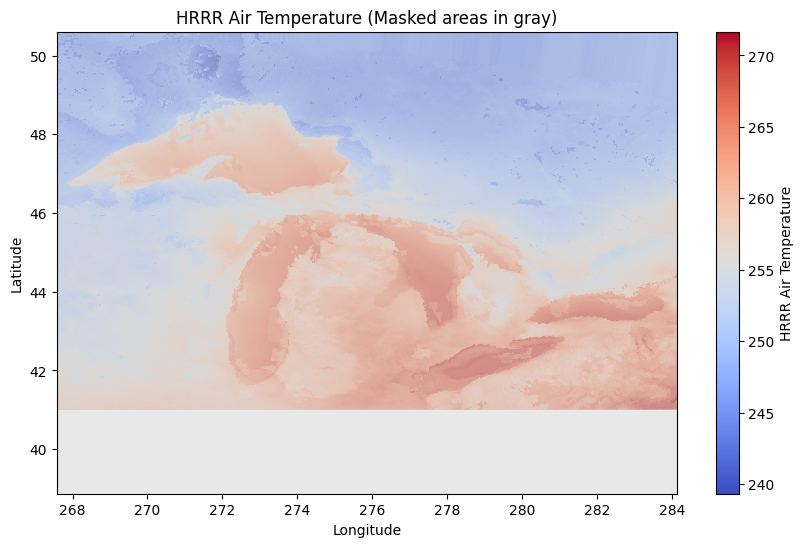

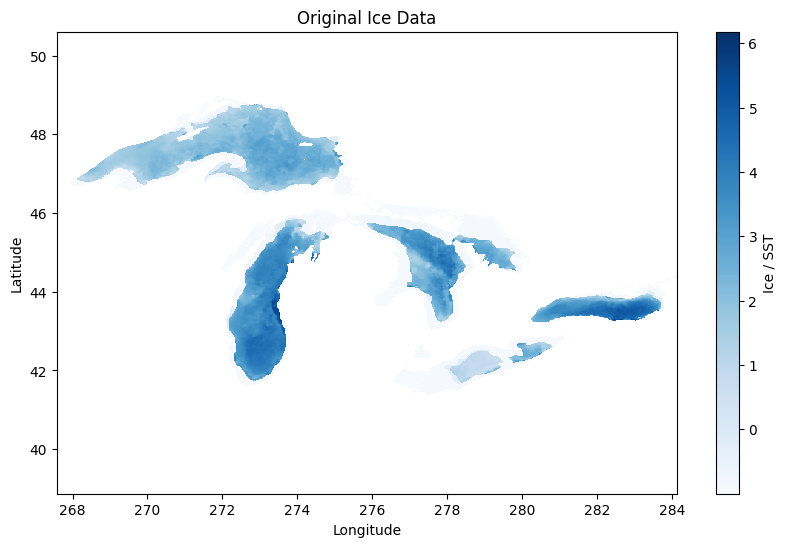

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Pick a timestep to visualize (e.g., t=0)
t = 0

# Function to plot a variable with mask overlay
def plot_with_mask(data, title, cmap='coolwarm'):
    plt.figure(figsize=(10, 6))
    mesh = plt.pcolormesh(ice_grid_lon, ice_grid_lat, data, shading='auto', cmap=cmap)
    plt.colorbar(mesh, label=title)
    # Overlay masked areas in gray
    plt.contourf(ice_grid_lon, ice_grid_lat, mask, colors='lightgray', alpha=0.5)
    plt.title(f"{title} (Masked areas in gray)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

# HRRR air temperature
plot_with_mask(hrrr_resampled['air_temp'][t], "HRRR Air Temperature")

# Optional: plot ice data itself for reference
plt.figure(figsize=(10, 6))
plt.pcolormesh(ice_grid_lon, ice_grid_lat, ice_ds['sst'].values, shading='auto', cmap='Blues')
plt.colorbar(label='Ice / SST')
plt.title("Original Ice Data")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [9]:
import xarray as xr
import numpy as np
from scipy.spatial import cKDTree
import sys
import os

# --- 1. Tuned Parameters (Provided by User) ---
T_FRZ_OFFSET = -0.548         # T_frz offset in C 
CH_CD = 1.059e-3              # Turbulent exchange coefficient (Ch/Cd)
F_BO = 2.074                  # Ocean Heat Flux (W/m^2)
C_RAIN = 1.0                  # Rain Heat Flux Scaling Factor
ALPHA_I = 0.7                 # Ice Albedo (0.0 - 1.0)

# --- 2. Fixed Physical Constants ---
DT = 3600.0                   # Time step in seconds (1 hour)
SIGMA = 5.67e-8               # Stefan-Boltzmann constant (W m^-2 K^-4)
CP_AIR = 1005.0               # Specific heat of air (J kg^-1 K^-1)
L_F = 3.34e5                  # Latent heat of fusion for ice (J kg^-1)
RHO_I = 917.0                 # Density of ice (kg m^-3)
R_AIR = 287.058               # Specific gas constant for dry air (J kg^-1 K^-1)
RHO_W = 1000.0                # Density of water (kg m^-3)
CP_WATER = 4186.0             # Specific heat capacity of water (J kg^-1 K^-1)
F_SW_DOWN = 100.0             # Assumed average incoming solar radiation (W/m^2)
H_MIN = 0.1                   # Minimum thickness for new ice formation (m)
A_NEW_ICE = 1.0               # Concentration of newly formed ice (1.0 or 100%)

# Calculate fixed T_FRZ in Kelvin and Celsius
T_FRZ_K = 273.15 + T_FRZ_OFFSET 
T_FRZ_C = T_FRZ_OFFSET

# --- 3. Data Loading and Resampling (Using Test Data) ---

print("STATUS: Loading test datasets...")
try:
    ice_ds  = xr.open_dataset("test/glsea_ice_test_initial_condition.nc")
    hrrr_ds = xr.open_dataset("test/hrrr_weather_test_period.nc")
    # gfs_ds is not used in this 5-parameter model, but loaded in user's reference code.
    # gfs_ds  = xr.open_dataset("test/gfs_weather_test_period.nc") 
except FileNotFoundError as e:
    print(f"Error loading file: {e}. Ensure 'test/' directory is correct.")
    sys.exit(1)

# --- Prepare ice grid coordinates ---
print("STATUS: Preparing Ice Grid coordinates and mask...")
ice_lat = ice_ds['lat'].values
ice_lon = np.mod(ice_ds['lon'].values, 360) 
ice_grid_lat, ice_grid_lon = np.meshgrid(ice_lat, ice_lon, indexing='ij')

# --- Mask for ice cells below 41 deg latitude ---
mask = ice_grid_lat < 41.0 

# --- HRRR Resampling Setup ---
weather_vars_hrrr = [
    "PRATE_surface", "air_temp", "pressure_sea_level",
    "rel_humidty", "sky_cover", "windu", "windv"
]

hrrr_lat = hrrr_ds['latitude'].values
hrrr_lon = np.mod(hrrr_ds['longitude'].values, 360)
hrrr_points = np.stack([hrrr_lat.ravel(), hrrr_lon.ravel()], axis=-1)

print("STATUS: Building cKDTree for HRRR resampling...")
tree = cKDTree(hrrr_points)
target_points = np.stack([ice_grid_lat.ravel(), ice_grid_lon.ravel()], axis=-1)
_, indices = tree.query(target_points)

hrrr_y = (indices // hrrr_lon.shape[1]).reshape(1024, 1024)
hrrr_x = (indices % hrrr_lon.shape[1]).reshape(1024, 1024)

hrrr_resampled = {}
for var in weather_vars_hrrr:
    resampled = hrrr_ds[var].values[:, hrrr_y, hrrr_x]
    
    # Preprocessing: Convert air temp to Celsius if needed
    if var == 'air_temp' and np.nanmean(resampled[0]) > 270: 
        resampled -= 273.15
        
    resampled[:, mask] = np.nan  # Apply mask
    hrrr_resampled[var] = resampled

print("HRRR resampling with mask complete.")

# --- Initial Conditions from Ice Data ---
# FIX: Changed 'temp' to 'sst' based on the KeyError
ice_data_initial = ice_ds['sst'].values 
A_INITIAL = np.where(ice_data_initial < 0, np.abs(ice_data_initial), 0.0)
H_INITIAL = np.where(A_INITIAL > 0.0, 0.5, 0.0) # Initial thickness assumed 0.5m for existing ice

# --- 4. Simulation Function ---

def ice_model_96h_forecast(A_initial, H_initial, hrrr_data):
    """
    Runs the 5-parameter, 0-layer thermodynamic ice model for 96 hours.
    """
    A_ice_current = A_initial.copy()
    H_ice_current = H_initial.copy()
    
    # Dictionary to store the concentration maps at 24, 48, 72, 96 hours
    output_concentrations = {}
    
    print(f"STATUS: Starting 96-hour simulation with fixed parameters...")

    for t in range(96):
        # 1. Extract and Pre-process Forcing Data (t+1 for forecast step)
        T_air_C = hrrr_data['air_temp'][t + 1] 
        T_air_K = T_air_C + 273.15 
        RH_air = hrrr_data['rel_humidty'][t + 1] / 100.0 
        CLOUD = hrrr_data['sky_cover'][t + 1] / 100.0
        U_wind = (hrrr_data['windu'][t + 1]**2 + hrrr_data['windv'][t + 1]**2)**0.5
        P_sl = hrrr_data['pressure_sea_level'][t + 1] 
        PRATE = hrrr_data['PRATE_surface'][t + 1] 
        
        # Fill NaNs with safe values
        U_wind = np.nan_to_num(U_wind, nan=0.0)
        T_air_K = np.nan_to_num(T_air_K, nan=T_FRZ_K)
        T_air_C = np.nan_to_num(T_air_C, nan=T_FRZ_C) 
        P_sl = np.nan_to_num(P_sl, nan=101325.0) 
        
        # Calculate Air Density
        RHO_AIR = P_sl / (R_AIR * T_air_K)
        RHO_AIR = np.nan_to_num(RHO_AIR, nan=1.25) 
        
        # 2. Calculate Heat Fluxes (F_net = F_surf - F_bo)
        
        # (a) Net Shortwave Absorbed (F_sw_net): 
        F_sw_net = F_SW_DOWN * (1.0 - ALPHA_I) * np.where(A_ice_current > 0.0, 1.0, 0.0)
        
        # (b) Longwave Down (L_down)
        L_down = SIGMA * T_air_K**4 * (0.8 + 0.2 * CLOUD) 
        
        # (c) Surface Longwave Up (L_up): Assumes ice surface is at T_frz
        L_up = 0.98 * SIGMA * T_FRZ_K**4
        
        # (d) Turbulent Fluxes (Qs, Ql)
        Q_sensible = RHO_AIR * CP_AIR * CH_CD * U_wind * (T_FRZ_K - T_air_K)
        Q_latent = RHO_AIR * L_F * 0.622 * CH_CD * U_wind * (RH_air - 1.0) 
        
        # (e) Rain Heat Flux (F_rain)
        T_diff = T_air_C - T_FRZ_C
        F_rain_unscaled = PRATE * RHO_W * CP_WATER * np.maximum(0.0, T_diff)
        F_rain = C_RAIN * F_rain_unscaled
        
        # (f) Net Surface Heat Flux (F_surf = F_cond)
        F_surf = F_sw_net + L_down - L_up + Q_sensible + Q_latent + F_rain
        
        # (g) Net Heat Flux at the Bottom Interface (F_net)
        F_net = F_surf - F_BO
        
        # 3. CALCULATE CHANGE IN THICKNESS (dH)
        dH = (F_net / (RHO_I * L_F)) * DT 

        # 4. APPLY CHANGES AND CONSTRAINTS
        
        # --- A. Existing Ice Growth/Melt (Vertical) ---
        dH_active = dH * np.where(A_ice_current > 0.0, 1.0, 0.0)
        H_ice_current += dH_active
        
        # --- Constraints (Binary Concentration Change) ---
        
        # 1. Melt-through: If H <= 0, Concentration A becomes 0.0
        H_ice_current[H_ice_current <= 0.0] = 0.0
        A_ice_current[H_ice_current == 0.0] = 0.0 # Binary Melt

        # 2. New Ice Formation: If A=0 and F_net < 0 (cooling water), new ice forms
        freezing_open_water = (A_ice_current == 0.0) & (F_net < 0.0)
        H_ice_current[freezing_open_water] = H_MIN
        A_ice_current[freezing_open_water] = A_NEW_ICE # Binary Growth
        
        # 5. SAVE OUTPUT
        time_step = t + 1
        if time_step in [24, 48, 72, 96]:
            output_concentrations[time_step] = A_ice_current.copy()
            print(f"-> Saved forecast for hour {time_step}")
            
    return output_concentrations

# --- 5. Main Execution and Output Saving ---

predicted_concentrations = ice_model_96h_forecast(A_INITIAL, H_INITIAL, hrrr_resampled)

# --- Save to .npz file (standard format for challenge submission) ---
output_filename = "ice_forecast_test_submission.npz"

# Prepare the data dictionary for saving
save_data = {
    'conc_24h': predicted_concentrations.get(24, np.empty((1024, 1024))),
    'conc_48h': predicted_concentrations.get(48, np.empty((1024, 1024))),
    'conc_72h': predicted_concentrations.get(72, np.empty((1024, 1024))),
    'conc_96h': predicted_concentrations.get(96, np.empty((1024, 1024)))
}

np.savez(output_filename, **save_data)
print(f"\nSUCCESS: 96-hour test forecast complete.")
print(f"Output saved to: {output_filename}")

STATUS: Loading test datasets...
STATUS: Preparing Ice Grid coordinates and mask...
STATUS: Building cKDTree for HRRR resampling...


/tmp/ipykernel_61255/2837084601.py:36: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  hrrr_ds = xr.open_dataset("test/hrrr_weather_test_period.nc")


HRRR resampling with mask complete.
STATUS: Starting 96-hour simulation with fixed parameters...
-> Saved forecast for hour 24
-> Saved forecast for hour 48
-> Saved forecast for hour 72
-> Saved forecast for hour 96

SUCCESS: 96-hour test forecast complete.
Output saved to: ice_forecast_test_submission.npz


The 'ice_forecast_test_submission.npz' file is a compressed NumPy archive containing four 1024x1024 arrays, named 'conc_24h', 'conc_48h', 'conc_72h', and 'conc_96h', representing the ice concentration forecast for each respective hour.
STATUS: Attempting to load forecast data from ice_forecast_test_submission.npz for plotting...
STATUS: Generating visualization...


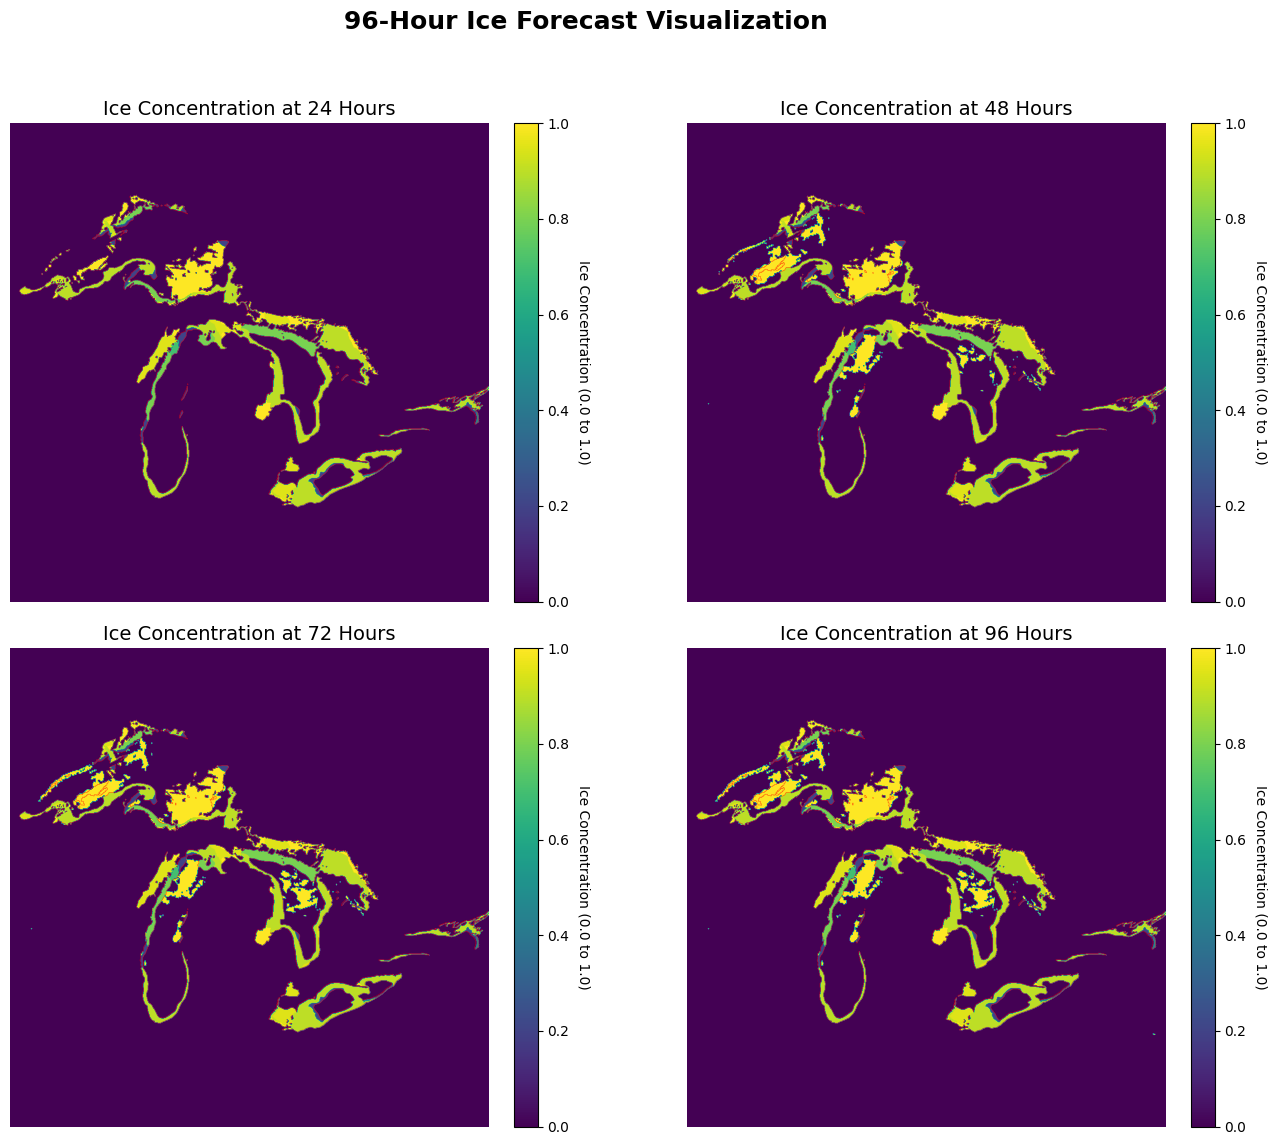

STATUS: Plotting complete.

STATUS: Preparing all concentration maps for separate JSON export...
SUCCESS: Vertically flipped data for conc_24h saved to ice_concentration_24h_flipped.json
SUCCESS: Vertically flipped data for conc_48h saved to ice_concentration_48h_flipped.json
SUCCESS: Vertically flipped data for conc_72h saved to ice_concentration_72h_flipped.json
SUCCESS: Vertically flipped data for conc_96h saved to ice_concentration_96h_flipped.json


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import json 

def plot_ice_forecast(filename="ice_forecast_test_submission.npz"):
    """
    Loads the forecasted ice concentrations from an .npz file and plots them.
    """
    print(f"STATUS: Attempting to load forecast data from {filename} for plotting...")
    
    if not os.path.exists(filename):
        print(f"ERROR: File not found: {filename}")
        print("Please ensure the 'ice_forecast_test_runner.py' script was run successfully first.")
        sys.exit(1)

    # Load data from the NumPy archive
    data = np.load(filename)
    
    # Extract the concentration arrays
    concentrations = {
        '24 Hours': data['conc_24h'],
        '48 Hours': data['conc_48h'],
        '72 Hours': data['conc_72h'],
        '96 Hours': data['conc_96h'],
    }
    
    # --- Plotting Setup ---
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()
    
    print("STATUS: Generating visualization...")

    for i, (title, conc_map) in enumerate(concentrations.items()):
        ax = axes[i]
        
        # Use a sequential colormap (e.g., 'Blues_r' for water/ice contrast)
        # Set vmin/vmax to 0 and 1 for consistent coloring of concentration
        # FIX: Added origin='lower' to flip the image vertically for correct orientation
        im = ax.imshow(conc_map, cmap='viridis', vmin=0.0, vmax=1.0, origin='lower') 
        
        # Overlay original ice outline (simplified visualization)
        # Find where concentration is > 0 in the initial state (assuming all initial concs are > 0)
        initial_ice = data['conc_24h']
        # The contour plot inherits the origin='lower' behavior from the imshow call
        ax.contour(initial_ice, levels=[0.01], colors='red', linewidths=0.5, alpha=0.5)

        ax.set_title(f'Ice Concentration at {title}', fontsize=14)
        ax.axis('off') # Turn off axes for a cleaner map view

        # Add a color bar
        cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
        cbar.set_label('Ice Concentration (0.0 to 1.0)', rotation=270, labelpad=15)

    # Global title and layout adjustments
    fig.suptitle('96-Hour Ice Forecast Visualization', fontsize=18, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    print("STATUS: Plotting complete.")


def export_all_concentrations(filename="ice_forecast_test_submission.npz"):
    """
    Loads all four forecasted ice concentrations, flips them vertically,
    and saves each as a separate list of lists (JSON format).
    """
    print(f"\nSTATUS: Preparing all concentration maps for separate JSON export...")
    
    try:
        data = np.load(filename)
        
        # Map of keys in the .npz file to the desired output filename prefix
        export_targets = {
            'conc_24h': 'ice_concentration_24h_flipped.json',
            'conc_48h': 'ice_concentration_48h_flipped.json',
            'conc_72h': 'ice_concentration_72h_flipped.json',
            'conc_96h': 'ice_concentration_96h_flipped.json',
        }

        for npz_key, output_file in export_targets.items():
            if npz_key in data:
                conc_map = data[npz_key]
                
                # Apply vertical flip as requested by the user
                conc_map_flipped = conc_map
                
                # Convert NumPy array (1024x1024 grid) to list of lists
                list_of_lists = conc_map_flipped.astype(float).tolist()
                
                with open(output_file, 'w') as f:
                    # Use json.dump for saving with indentation for readability
                    json.dump(list_of_lists, f, indent=2)
                    
                print(f"SUCCESS: Vertically flipped data for {npz_key} saved to {output_file}")
            else:
                 print(f"WARNING: Key '{npz_key}' not found in the input .npz file.")
        
    except FileNotFoundError:
        print(f"ERROR: Could not find input file {filename} for export.")
    except Exception as e:
        print(f"An unexpected error occurred during export: {e}")


if __name__ == "__main__":
    # The first question was about the content of the file.
    # The 'ice_forecast_test_submission.npz' file contains four 1024x1024 NumPy arrays:
    # 'conc_24h', 'conc_48h', 'conc_72h', and 'conc_96h'.
    print("The 'ice_forecast_test_submission.npz' file is a compressed NumPy archive containing four 1024x1024 arrays, named 'conc_24h', 'conc_48h', 'conc_72h', and 'conc_96h', representing the ice concentration forecast for each respective hour.")
    
    # Run the plotting and the new export function
    plot_ice_forecast()
    export_all_concentrations()

STATUS: Loading data from ice_concentration_96h_flipped.json for verification...
SUCCESS: Data loaded. Shape: (1024, 1024)


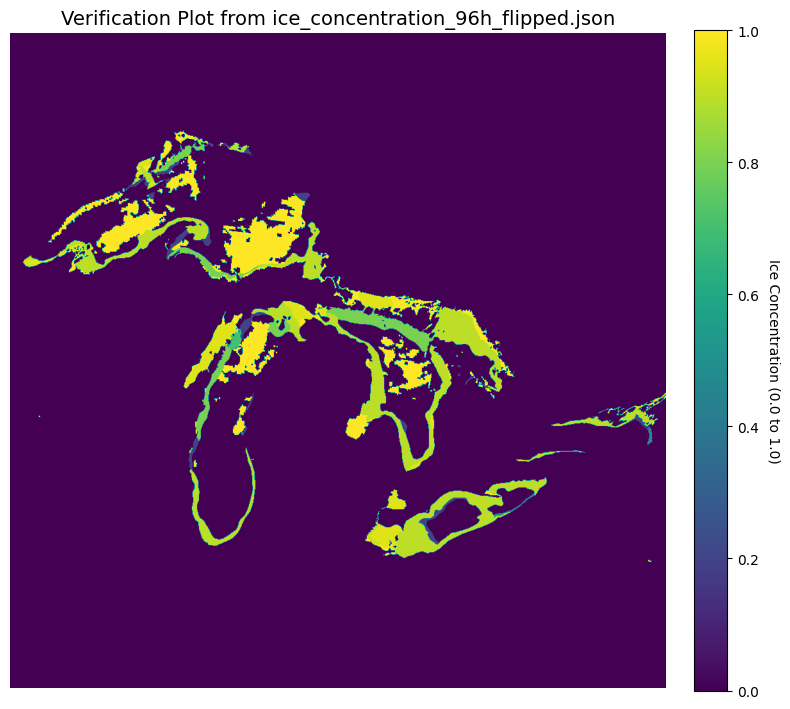

STATUS: Verification plot displayed.


In [16]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

def verify_and_plot_json(json_filename="ice_concentration_96h_flipped.json"):
    """
    Loads ice concentration data from a JSON file (list of lists),
    converts it back to a NumPy array, and plots the result.
    """
    print(f"STATUS: Loading data from {json_filename} for verification...")
    
    if not os.path.exists(json_filename):
        print(f"ERROR: JSON file not found: {json_filename}")
        print("Please ensure 'plot_forecast.py' was run to generate the export files.")
        sys.exit(1)

    try:
        # 1. Load the list of lists from the JSON file
        with open(json_filename, 'r') as f:
            list_of_lists = json.load(f)

        # 2. Convert the list of lists back into a NumPy array
        # This array is already vertically flipped due to the export process
        conc_map = np.array(list_of_lists)
        
        if conc_map.shape != (1024, 1024):
            print(f"WARNING: Expected shape (1024, 1024), but loaded shape is {conc_map.shape}")

        print(f"SUCCESS: Data loaded. Shape: {conc_map.shape}")

        # 3. Plotting the verified data
        plt.figure(figsize=(8, 8))
        
        # We use origin='lower' here because the data was flipped *before* saving.
        # This ensures the plot matches the orientation of the original forecast model.
        im = plt.imshow(conc_map, cmap='viridis', vmin=0.0, vmax=1.0, origin='lower')
        
        plt.title(f'Verification Plot from {json_filename}', fontsize=14)
        plt.axis('off')

        cbar = plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)
        cbar.set_label('Ice Concentration (0.0 to 1.0)', rotation=270, labelpad=15)
        
        plt.tight_layout()
        plt.show()
        print("STATUS: Verification plot displayed.")

    except json.JSONDecodeError:
        print(f"ERROR: Failed to decode JSON from {json_filename}. File structure may be invalid.")
    except Exception as e:
        print(f"An unexpected error occurred during verification: {e}")

if __name__ == "__main__":
    verify_and_plot_json()